## Importação dos pacotes

In [1]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [2]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# importar os pacotes necessários para os algoritmos de regressão
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

## Carga dos dados de entrada

In [9]:
# carregar arquivo de dados de treino
filename = 'abalone-train.csv'
#filename = 'abalone-train-o1-0.50.csv' # removidos outliers
#filename = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-abalone/abalone-train.csv'
data = pd.read_csv(filename, index_col='id')

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(2784, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
2758,M,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,F,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,M,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,I,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,I,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [10]:
# remover coluna "sex"
#data = data.join(data_sex)
data.drop('sex', axis=1, inplace=True)
data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,
2758,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [11]:
X = data.drop(['rings'], axis=1)
y = data['rings']

model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(X, y)

data['predict'] = model.predict(X)
data['diff'] = abs(data.rings - data.predict)

# definir o limiar para ser considerado anomalia
limiar = data['diff'].mean() + 1.5 * data['diff'].std()

# selecionar os outliers
outliers = data[data['diff'] > limiar].index

data.drop(['predict', 'diff'], axis=1, inplace=True)

In [12]:
print("Número de outliers a serem removidos: %d" % len(outliers))

print("Antes:", data.shape)
data.drop(outliers, inplace=True)
print("Depois:", data.shape)

Número de outliers a serem removidos: 219
Antes: (2784, 8)
Depois: (2565, 8)


In [13]:
# definir dados de entrada

X = data.drop(['rings'], axis=1) # tudo, exceto a coluna alvo
y = data['rings'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (2565, 7) (2565,)


## Treinamento dos modelos preditivos

In [14]:
from sklearn.metrics import make_scorer, mean_squared_error

# cria função para cálculo do RMSE (REMQ)
def root_mean_squared_error(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(root_mean_squared_error, greater_is_better=False)

In [15]:
from datetime import datetime

# avalia o desempenho do modelo, retornando o valor do RMSE
def evaluate_model_cv(model, X=X, y=y):
    start = datetime.now()
    kfold = KFold(n_splits=10, random_state=42)
    results = cross_val_score(model, X, y, cv=kfold, scoring=RMSE, verbose=1)
    end = datetime.now()
    elapsed = int((end - start).total_seconds() * 1000)
    score = (-1) * results.mean()
    stddev = results.std()
    print(model, '\nScore: %.2f (+/- %.2f) [%5s ms]' % (score, stddev, elapsed))
    return score, stddev, elapsed

In [16]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)
  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring=RMSE, cv=kfold, verbose=1)
  grid.fit(X, y)
  print('\nGrid Best Score: %.2f' % (grid.best_score_ * (-1)))
  print('Best Params:', grid.best_params_)
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

-  https://scikit-learn.org/stable/modules/classes.html

### Generalized Linear Models

In [18]:
model = LinearRegression(n_jobs=2, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = dict(
    fit_intercept=[True, False],
    normalize=[True, False]
)
fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=True) 
Score: 1.54 (+/- 0.07) [ 1689 ms]

Fine Tuning Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=True) 
params: {'fit_intercept': [True, False], 'normalize': [True, False]}
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Grid Best Score: 1.54
Best Params: {'fit_intercept': True, 'normalize': True}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=2, normalize=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
       verbose=1)

In [13]:
model = LogisticRegression(n_jobs=2, random_state=42, multi_class='auto', C=1000, solver='newton-cg')
evaluate_model_cv(model)

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C':np.logspace(-3,3,7)
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto', n_jobs=2,
          penalty='l2', random_state=42, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 
Score: 2.37 (+/- 0.21) [520761 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.7min finished


In [14]:
model = OrthogonalMatchingPursuit(n_nonzero_coefs=7, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = {
    'n_nonzero_coefs': [None, 1, 2, 5, 7],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=8,
             normalize=True, precompute='auto', tol=None) 
Score: 2.16 (+/- 0.17) [  659 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [15]:
model = PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)
evaluate_model_cv(model)

params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.0],
    'fit_intercept': [True, False],
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=1000, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.22 (+/- 0.19) [  740 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [27]:
model = Perceptron(random_state=42, penalty=None, alpha=1e-6, fit_intercept=True, max_iter=1000, tol=1e-3)
evaluate_model_cv(model)

#penalty=None, alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0,
#n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, 
#class_weight=None, warm_start=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-06, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=1000, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=42, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.70 (+/- 0.60) [ 3223 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


In [20]:
model = RANSACRegressor(random_state=42, min_samples=0.75)
evaluate_model_cv(model)

#base_estimator=None, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None,
#max_trials=100, max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss=’absolute_loss’,
#random_state=None

params = {
    'min_samples': [None, 0.1, 0.25, 0.5, 0.75, 1.0]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 1.56 (+/- 0.07) [13829 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


In [21]:
model = Ridge(random_state=42, alpha=0.1, fit_intercept=False, normalize=True)
evaluate_model_cv(model)

#alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’,
#random_state=None

params = {
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 1.58 (+/- 0.07) [  636 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [22]:
model = SGDRegressor(random_state=42, alpha=1e-06, fit_intercept=True, penalty=None, tol=1e-3)
evaluate_model_cv(model)

#loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
#shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25,
#early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Score: 1.67 (+/- 0.08) [ 5808 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


In [20]:
model = TheilSenRegressor(random_state=42, n_jobs=2, fit_intercept=True)
evaluate_model_cv(model)

#fit_intercept=True, copy_X=True, max_subpopulation=10000.0, n_subsamples=None, 
#max_iter=300, tol=0.001, random_state=None, n_jobs=None, verbose=False

params = {
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=2, n_subsamples=None,
         random_state=42, tol=0.001, verbose=False) 
Score: 2.18 (+/- 0.17) [88550 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


### Decision Trees

In [28]:
model = DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_split=0.25)
evaluate_model_cv(model)

#criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, presort=False

params = dict(
    max_depth=[4, 6, 8, 10, 12, 14],
    min_samples_split=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Score: 1.83 (+/- 0.09) [  535 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


### Gaussian Processes

In [22]:
model = GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=False)
evaluate_model_cv(model)

#kernel=None, alpha=1e-10, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0,
#normalize_y=False, copy_X_train=True, random_state=None

params = dict(
    alpha=np.logspace(-6, -1, 6),
    normalize_y=[True, False]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 2.06 (+/- 0.16) [113911 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


### Kernel Ridge Regression

In [23]:
model = KernelRidge()
evaluate_model_cv(model)

#alpha=1, kernel=’linear’, gamma=None, degree=3, coef0=1, kernel_params=None

params = dict(
    alpha=np.logspace(-6, -1, 6)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None) 
Score: 2.17 (+/- 0.18) [62290 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


### Naïve Bayes

In [23]:
model = GaussianNB(var_smoothing=0.1)
evaluate_model_cv(model)

#priors=None, var_smoothing=1e-09

params = dict(
    var_smoothing=np.logspace(-9, -1, 5)
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=0.1) 
Score: 2.33 (+/- 0.13) [  765 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


### Nearest Neighbors

In [24]:
model = KNeighborsRegressor(n_jobs=2, n_neighbors=13, weights='distance')
evaluate_model_cv(model)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#metric_params=None, n_jobs=None

params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=2, n_neighbors=13, p=2,
          weights='distance') 
Score: 1.54 (+/- 0.05) [ 9466 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s finished


### Support Vector Machines

In [26]:
model = SVR(gamma='auto', kernel='linear')
evaluate_model_cv(model)

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.29 (+/- 0.22) [18578 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished


### Neural network models

In [27]:
model = MLPRegressor(random_state=42, max_iter=500,
                     activation='logistic', hidden_layer_sizes=(50,), solver='lbfgs')
evaluate_model_cv(model)

#hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, 
#learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
#random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10

params = dict(
    hidden_layer_sizes=[(100,), (50,), (50,2)],
    activation=['identity', 'logistic', 'tanh', 'relu'],
    solver=['lbfgs', 'sgd', 'adam']
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 2.07 (+/- 0.14) [260216 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished


### Ensemble Methods

In [28]:
model = RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#verbose=0, warm_start=False

params = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [None, 3, 5, 7, 9, 11, 13]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 2.11 (+/- 0.18) [30721 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.7s finished


In [29]:
model = GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.4, max_depth=6, max_features=1.0)
evaluate_model_cv(model)

#loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
#min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, 
#max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, 
#tol=0.0001

params = dict(
    n_estimators=[100, 250, 500, 750, 1000],
    max_features=[0.5, 0.75, 0.85, 1.0],
    max_depth=[4, 6, 8, 10, 12, 14],
    learning_rate=[0.05, 0.1, 0.15, 0.2],
    subsample=[0.4, 0.6, 0.8]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.4, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.11 (+/- 0.19) [22549 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.5s finished


In [30]:
model = ExtraTreesRegressor(random_state=42, n_jobs=2, n_estimators=200, max_features=1.0)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0,
#warm_start=False

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200],
    max_features=['auto', 0.5, 0.75, 0.85, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
          oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 2.16 (+/- 0.18) [54819 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.8s finished


In [25]:
model = BaggingRegressor(random_state=42, n_jobs=2, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

#base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, 
#bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200],
    max_features=[0.25, 0.5, 0.75, 1.0]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=2, oob_score=False,
         random_state=42, verbose=0, warm_start=False) 
Score: 1.63 (+/- 0.09) [ 6283 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.3s finished


In [32]:
model = AdaBoostRegressor(random_state=42, n_estimators=100, base_estimator=DecisionTreeRegressor())
evaluate_model_cv(model)

# base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, random_state=None

params = dict(
    n_estimators=[10, 25, 50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=42) 
Score: 2.21 (+/- 0.18) [91656 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


### Outros algoritmos

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [26]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                     n_estimators=50, max_depth=5, objective='reg:squarederror')
evaluate_model_cv(model)

#max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:squarederror',
#booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
#colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
#base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain'

params = dict(
    max_depth=[3, 5, 7, 9],
    n_estimators=[10, 25, 50, 75, 100, 200]
)
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=2, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1) 
Score: 1.54 (+/- 0.07) [11726 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


### Ensemble Learning Model

- https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
- https://github.com/vecxoz/vecstack

## Comparação final entre os algoritmos

In [38]:
models = []

# Generalized Linear Models
models.append(('LinReg', LinearRegression(n_jobs=2, fit_intercept=False, normalize=True)))
models.append(('LogReg', LogisticRegression(n_jobs=2, random_state=42, multi_class='auto', C=1000, solver='newton-cg')))
models.append(('OMP', OrthogonalMatchingPursuit(n_nonzero_coefs=8, fit_intercept=True, normalize=True)))
models.append(('PAR', PassiveAggressiveRegressor(random_state=42, C=0.1, fit_intercept=True, max_iter=1000, tol=0.001)))
models.append(('PP', Perceptron(random_state=42, penalty='l2', alpha=1e-5, fit_intercept=True, max_iter=1000, tol=1e-3)))
models.append(('RANSAC', RANSACRegressor(random_state=42, min_samples=0.75)))
models.append(('Ridge', Ridge(random_state=42, alpha=0.1, fit_intercept=False, normalize=True)))
models.append(('SGD', SGDRegressor(random_state=42, alpha=1e-06, fit_intercept=True, penalty=None, tol=1e-3)))
models.append(('TSR', TheilSenRegressor(random_state=42, n_jobs=2, fit_intercept=True)))

# Decision Trees
models.append(('DTR', DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_split=0.25)))

# Gaussian Processes
models.append(('GPR', GaussianProcessRegressor(random_state=42, alpha=0.01, normalize_y=True)))

# Kernel Ridge Regression
models.append(('KRR', KernelRidge()))

# Naïve Bayes
models.append(('GNB', GaussianNB(var_smoothing=0.1)))

# Nearest Neighbors
models.append(('kNN', KNeighborsRegressor(n_jobs=2, n_neighbors=13, weights='distance')))

# Support Vector Machines
models.append(('SVM', SVR(gamma='auto', kernel='linear')))

# Neural network models
models.append(('MLP', MLPRegressor(random_state=42, max_iter=500,
                     activation='logistic', hidden_layer_sizes=(50,), solver='lbfgs')))

# Ensemble Methods
models.append(('RFR', RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7)))
models.append(('GBR', GradientBoostingRegressor(random_state=42, learning_rate=0.05, n_estimators=100,
                                  subsample=0.4, max_depth=6, max_features=1.0)))
models.append(('ETR', ExtraTreesRegressor(random_state=42, n_jobs=2, n_estimators=200, max_features=1.0)))
models.append(('BDTR', BaggingRegressor(random_state=42, n_jobs=2, base_estimator=DecisionTreeRegressor())))
models.append(('ABDTR', AdaBoostRegressor(random_state=42, n_estimators=100, base_estimator=DecisionTreeRegressor())))

# XGBoost
models.append(('XGBR', XGBRegressor(random_state=42, n_jobs=2, learning_rate=0.1,
                                    n_estimators=50, max_depth=5, objective='reg:squarederror')))

In [39]:
results = []
names = []
scores = []
stddevs = []
times = []

for name, model in models:
    score, stddev, elapsed = evaluate_model_cv(model, X=X, y=y)
    results.append((score, stddev))
    names.append(name)
    scores.append(score)
    stddevs.append(stddev)
    times.append(elapsed)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True) 
Score: 2.16 (+/- 0.17) [  450 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto', n_jobs=2,
          penalty='l2', random_state=42, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 
Score: 2.37 (+/- 0.21) [456814 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=8,
             normalize=True, precompute='auto', tol=None) 
Score: 2.16 (+/- 0.17) [  540 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


PassiveAggressiveRegressor(C=0.1, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=1000, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.22 (+/- 0.19) [  818 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=1e-05, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=1000, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l2', random_state=42, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 3.81 (+/- 1.07) [ 3457 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Score: 2.19 (+/- 0.18) [12108 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Score: 2.16 (+/- 0.17) [  358 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Score: 2.24 (+/- 0.20) [ 7573 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=2, n_subsamples=None,
         random_state=42, tol=0.001, verbose=False) 
Score: 2.18 (+/- 0.17) [88606 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=0.25, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Score: 2.42 (+/- 0.17) [  561 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=42) 
Score: 2.06 (+/- 0.16) [106398 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None) 
Score: 2.17 (+/- 0.18) [51932 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=0.1) 
Score: 2.92 (+/- 0.21) [  713 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=2, n_neighbors=13, p=2,
          weights='distance') 
Score: 2.19 (+/- 0.18) [ 1326 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Score: 2.29 (+/- 0.22) [18587 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Score: 2.07 (+/- 0.14) [257159 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 2.11 (+/- 0.18) [32120 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.4, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 2.11 (+/- 0.19) [22549 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   52.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
          oob_score=False, random_state=42, verbose=0, warm_start=False) 
Score: 2.16 (+/- 0.18) [52917 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=2, oob_score=False,
         random_state=42, verbose=0, warm_start=False) 
Score: 2.23 (+/- 0.16) [ 6054 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=42) 
Score: 2.21 (+/- 0.18) [91761 ms]


/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/p

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=2, nthread=None, objective='reg:squarederror',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1) 
Score: 2.12 (+/- 0.19) [ 8563 ms]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished


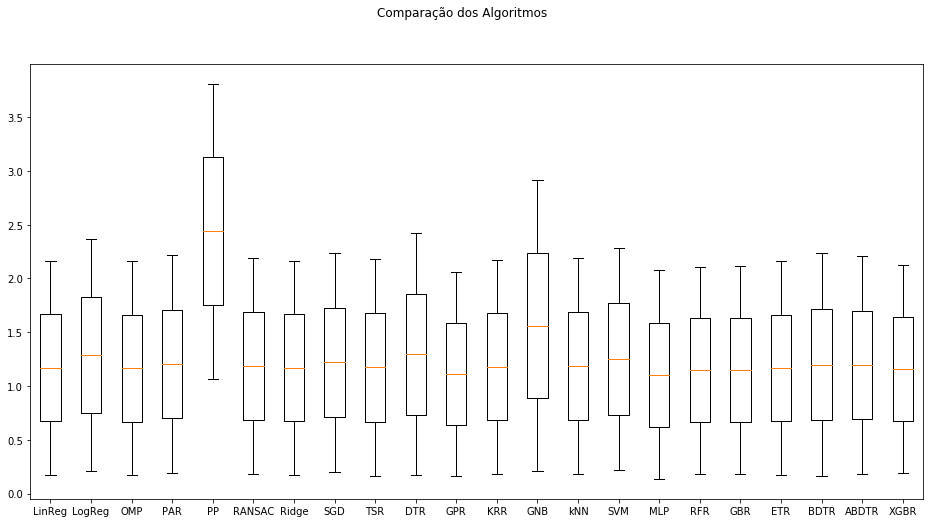

In [40]:
# comparar desempenhos dos algoritmos
fig = plt.figure(figsize=(16,8))
fig.suptitle('Comparação dos Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [41]:
results_df = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs, 'Time (ms)': times})
results_df.sort_values(by='Score', ascending=True)

,Model,Score,Std Dev,Time (ms)
10,GPR,2.064180,0.162498,106398
15,MLP,2.074386,0.135121,257159
16,RFR,2.110647,0.182089,32120
17,GBR,2.114125,0.185441,22549
21,XGBR,2.121650,0.191928,8563
18,ETR,2.159682,0.176824,52917
2,OMP,2.161869,0.172695,540
6,Ridge,2.162257,0.174285,358
0,LinReg,2.162596,0.172837,450
11,KRR,2.173249,0.184312,51932
